In [1]:
import os
import numpy as np
import LMCE.cfusdlog as cfusdlog

import LMCE.uav_trajectory as uav_trajectory
from LMCE.error_estimation import error_calculator, find_best_cutoff

In [2]:
folder_path = "./inditest"

# TABLE_DESCRIPTION = "Comparison of average deviation from desired flight path (meters) of the quadrotor carrying a payload."
TABLE_DESCRIPTION = "Comparison of average deviation from desired flight path (meters) of the quadrotor with no payload."

NN_KEY = "nn"
INDI_KEY = "indi"

# Get desired path
traj = uav_trajectory.Trajectory()
traj.loadcsv("./LMCE/flight_paths/figure8.csv")
traj.stretchtime(2)

ts = np.arange(0, traj.duration, 0.01)
evals = np.empty((len(ts), 15))
for t, i in zip(ts, range(0, len(ts))):
    e = traj.eval(t)
    e.pos += np.array([0, 0, 1])
    evals[i, 0:3] = e.pos

target_pos = evals.transpose()

203 520 717


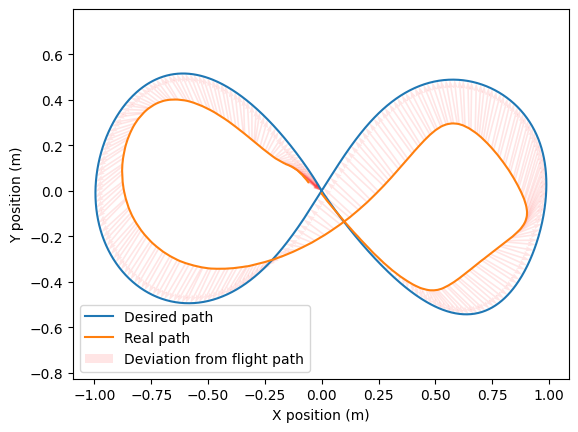

167 480 681


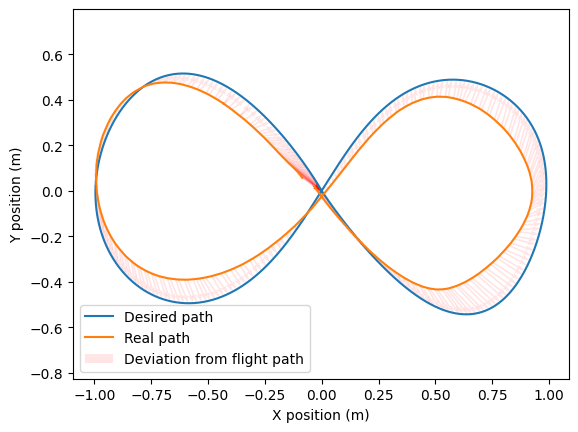

201 570 767


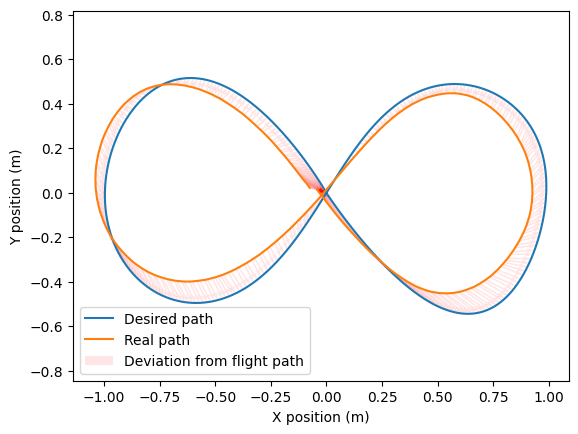

202 574 767


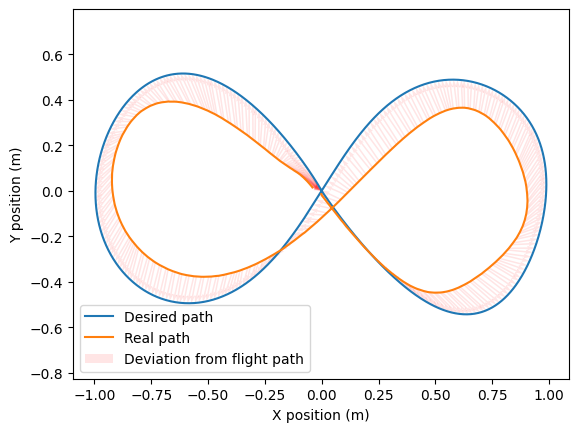

In [3]:
errors = [[] for i in range(4)]

for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    
    data = cfusdlog.decode(file_path)['fixedFrequency']

    using_nn = NN_KEY in data.keys() and sum(data[NN_KEY])
    using_indi = INDI_KEY in data.keys() and sum(data[INDI_KEY])

    real_pos = [data["stateEstimate.x"], data["stateEstimate.y"] - 1.]

    # Calculate error
    start_cutoff, end_cutoff = find_best_cutoff(real_pos, target_pos)
    print(start_cutoff, end_cutoff, len(real_pos[0]))
    error = error_calculator(real_pos, target_pos, start_cutoff, end_cutoff, vis=True)

    if using_nn and using_indi:
        errors[3].append(error)
    elif using_nn:
        errors[2].append(error)
    elif using_indi:
        errors[1].append(error)
    else:
        errors[0].append(error)

errors = [sum(e)/len(e) if len(e) != 0 else 0 for e in errors]

In [4]:
min_error = min(errors)

error_strs = [f"$\mathbf{{{e}}}$" if e == min_error else f"{e}" for e in errors]

latex_text = f"""\\begin{{table}}[htbp]
  \centering
  \caption{{{TABLE_DESCRIPTION}}}
  \\begin{{tabular}}{{|c|c|}}
    \hline
    Flight Contoller & avg. error (m) \\\\
    \hline
    Lee & {error_strs[0]} \\\\
    \hline
    Lee+INDI & {error_strs[1]} \\\\
    \hline
    Lee+MLP & {error_strs[2]} \\\\
    \hline
    Lee+INDI+MLP & {error_strs[3]} \\\\
    \hline
  \end{{tabular}}
  \label{{tab:results_payload}}
\end{{table}}"""

In [5]:
print(latex_text)

\begin{table}[htbp]
  \centering
  \caption{Comparison of average deviation from desired flight path (meters) of the quadrotor with no payload.}
  \begin{tabular}{|c|c|}
    \hline
    Flight Contoller & avg. error (m) \\
    \hline
    Lee & 0.09975686445859114 \\
    \hline
    Lee+INDI & $\mathbf{0}$ \\
    \hline
    Lee+MLP & $\mathbf{0}$ \\
    \hline
    Lee+INDI+MLP & $\mathbf{0}$ \\
    \hline
  \end{tabular}
  \label{tab:results_payload}
\end{table}
